In [1]:
import pandas as pd

# Data
df_partition = pd.read_csv("average_network_partition.csv", index_col=[0])
df_individuals_raw = pd.read_csv('../networks/data/global_before_1700.csv', index_col=[0])

df_partition['community'] = df_partition['community'].astype(int)
mapping = {0:'Human Domain', 1:'Natural Domain', 2:'Abstract Domain'}
df_partition['domain'] = df_partition['community'].apply(lambda x: mapping.get(x))

In [2]:
df_individuals = df_individuals_raw[['wikidata_id', 'individual_name', 'region_name', 'meta_occupation']].copy()
df_individuals['meta_occupation']  = df_individuals['meta_occupation'].apply(lambda x: x.split(' |'))
df_individuals = df_individuals.explode('meta_occupation')
df_individuals = df_individuals.rename(columns={'meta_occupation':'node'})
df_individuals = pd.merge(df_individuals, df_partition, on = 'node')
df_individuals = df_individuals.drop_duplicates(['wikidata_id', 'domain'], keep='first')

In [3]:
for domain in df_individuals['domain'].unique():
    print(domain)
    df_domain = df_individuals[df_individuals['domain']==domain]
    df_domain = df_domain[['wikidata_id', 'node']].drop_duplicates()
    print(df_domain['node'].value_counts().head(3))

Human Domain
theologian     4914
historian      2741
philosopher    1766
Name: node, dtype: int64
Abstract Domain
astronomer       711
mathematician    614
musicologist     278
Name: node, dtype: int64
Natural Domain
geographer    699
botanist      472
anatomist     161
Name: node, dtype: int64


In [4]:
# Remove those for original graph with original datasets
bigger_regions = {'Central Europe':'Eastern Europe', 
                  'Slav world':'Eastern Europe',
                  'Balkans':'Eastern Europe',
                  'Korea':'Asia',
                  'Chinese world':'Asia', 
                  'Japan':'Asia', 
                  'Indian world':'Asia',
                  'South East Asia':'Asia', 
                  'Greek World':'Ancient Mediterranean', 
                  'Latin World':'Ancient Mediterranean',
                  'Arabic world':'MENA',
                  'Persian world':'MENA',
                  'Ottoman Turkey':'MENA',
                  'Spain':'Iberian Peninsula',
                  'Portugal':'Iberian Peninsula'}

df_individuals['region_name'] = df_individuals['region_name'].apply(lambda x: bigger_regions.get(x, x))
set(df_individuals['region_name'])

df_individuals


,wikidata_id,individual_name,region_name,node,community,domain
0,Q316119,Gnaeus Pompeius Trogus,Ancient Mediterranean,historian,0,Human Domain
1,Q2891791,Latinius Pacatus Drepanius,Ancient Mediterranean,historian,0,Human Domain
2,Q885870,Victorinus Junior,Ancient Mediterranean,historian,0,Human Domain
3,Q336704,Sulpicius Severus,Ancient Mediterranean,historian,0,Human Domain
4,Q188646,Lucan,Ancient Mediterranean,historian,0,Human Domain
...,...,...,...,...,...,...
14210,Q1478500,Johannes Ralla,German world,pharmacologist,1,Natural Domain
14211,Q73983,Johann Schröder,German world,pharmacologist,1,Natural Domain
14212,Q60377771,Johann Francke,German world,pharmacologist,1,Natural Domain
14213,Q1679093,Jakob Hendrik Croeser,Low countries,pharmacologist,1,Natural Domain


In [5]:
# Group the data by region and domain and calculate the percentages
df_country = df_individuals.groupby(['region_name', 'domain'])['wikidata_id'].count().rename('count_domains').reset_index()
df_country = df_country.groupby(['region_name', 'domain']).agg({'count_domains': 'sum'})
df_country = df_country.reset_index()

# # Create a DataFrame with all possible combinations of region_name and domain
# all_regions = df_country['region_name'].unique()
# all_domains = df_country['domain'].unique()
# all_combinations = [(r, d) for r in all_regions for d in all_domains]
# df_all_combinations = pd.DataFrame(all_combinations, columns=['region_name', 'domain'])

# merged_data = pd.merge(df_all_combinations, df_country, on=['region_name', 'domain'], how='left')
# merged_data['count_domains'] = merged_data['count_domains'].fillna(0)
# merged_data

#df_country = merged_data.copy()
df_country = df_country.set_index('region_name')
df_country['percent'] = (df_country['count_domains'] / df_country.groupby('region_name')['count_domains'].transform('sum')) * 100
#df_country['percent'] = round(df_country['percent'], 1)
df_country = df_country.reset_index()
df_country


,region_name,domain,count_domains,percent
0,Ancient Mediterranean,Abstract Domain,78,11.872146
1,Ancient Mediterranean,Human Domain,553,84.170472
2,Ancient Mediterranean,Natural Domain,26,3.957382
3,Asia,Abstract Domain,115,16.083916
4,Asia,Human Domain,545,76.223776
5,Asia,Natural Domain,55,7.692308
6,British Islands,Abstract Domain,159,16.044400
7,British Islands,Human Domain,651,65.691221
8,British Islands,Natural Domain,181,18.264379
9,Eastern Europe,Abstract Domain,142,13.027523


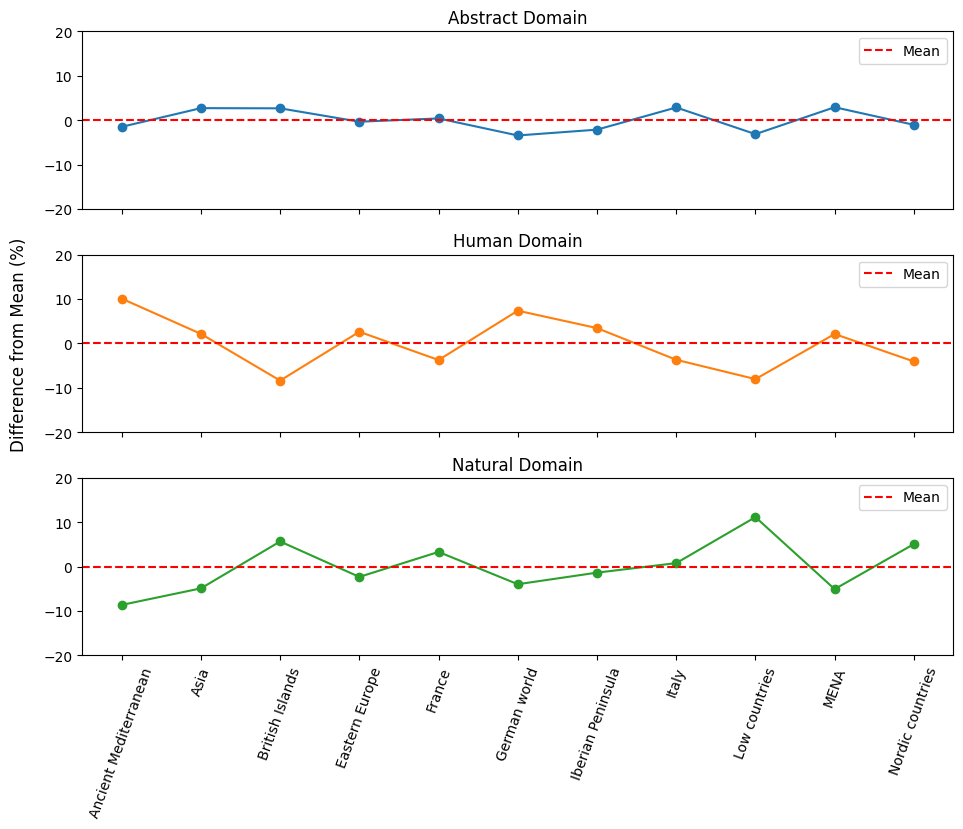

In [18]:
# Calculate the mean percentage for each domain
mean_percentages = df_country.groupby('domain')['percent'].mean()

import matplotlib.pyplot as plt

# Create a new column for the difference from the mean
df_country['difference_from_mean'] = df_country.apply(lambda row: row['percent'] - mean_percentages[row['domain']], axis=1)

# Create a single graph with three subplots stacked on top of each other
fig, axs = plt.subplots(3, 1, figsize=(10, 7), sharex=True)  # Adjust the height (7) as needed

# List of unique domains
domains = df_country['domain'].unique()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Choose nicer colors

random_df = pd.read_csv('domain_variations/random_spaces.csv', index_col = [0])


for i, domain in enumerate(domains):



    domain_data = df_country[df_country['domain'] == domain]
    axs[i].plot(domain_data['region_name'], domain_data['difference_from_mean'], marker='o', linestyle='-', color=colors[i])

    # random_data = random_df[random_df['domain'] == domain]
    # axs[i].plot(random_data['region_name'], random_data['difference_from_mean'], marker='x', linestyle='-', color=colors[i], alpha = 0.5, label = 'Simulated Data')

    axs[i].axhline(y=0, color='r', linestyle='--', label='Mean')
    #axs[i].set_ylabel('Difference from Mean (%)')
    axs[i].set_title(f'{domain}')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    axs[i].legend(loc='upper right')
    
    # Set the y-axis limits to -100 to 100
    axs[i].set_ylim(-20, 20)
    
    axs[i].legend()
    axs[i].grid(False)

# Add a unique ylabel
fig.supylabel('Difference from Mean (%)')

plt.tight_layout()
plt.xticks(rotation=70)
plt.show()


In [7]:
df_pivot = df_country.pivot(index='region_name', columns='domain', values='difference_from_mean')
df_pivot.corr(method='pearson')

domain,Abstract Domain,Human Domain,Natural Domain
domain,,,
Abstract Domain,1.000000,-0.279674,-0.134687
Human Domain,-0.279674,1.000000,-0.913678
Natural Domain,-0.134687,-0.913678,1.000000


In [8]:
df_stats = df_country[['region_name', 'domain', 'difference_from_mean']].copy()
domain_variance = df_stats.groupby('domain')['difference_from_mean'].std()
domain_variance

domain
Abstract Domain    2.473303
Human Domain       6.029870
Natural Domain     5.842483
Name: difference_from_mean, dtype: float64

In [9]:
df_stats = df_country[['region_name', 'domain', 'percent']].copy()
domain_variance = df_stats.groupby('domain')['percent'].std()
domain_variance

domain
Abstract Domain    2.473303
Human Domain       6.029870
Natural Domain     5.842483
Name: percent, dtype: float64

## For time

In [10]:
import numpy as np
df_individuals_time = df_individuals_raw[['wikidata_id', 'individual_name', 'birthyear', 'meta_occupation']].copy()


df_individuals_time= df_individuals_time[df_individuals_time['birthyear'] >=-600]
df_individuals_time['century'] = df_individuals_time['birthyear'].apply(lambda x : np.round(np.array(x) / 200) * 200
)


df_individuals_time['meta_occupation']  = df_individuals_time['meta_occupation'].apply(lambda x: x.split(' |'))
df_individuals_time = df_individuals_time.explode('meta_occupation')
df_individuals_time = df_individuals_time.rename(columns={'meta_occupation':'node'})
df_individuals_time = pd.merge(df_individuals_time, df_partition, on = 'node')
df_individuals_time = df_individuals_time.drop_duplicates(['wikidata_id', 'domain'], keep='first')


# Group the data by region and domain and calculate the percentages
df_time = df_individuals_time.groupby(['century', 'domain'])['wikidata_id'].count().rename('count_domains').reset_index()
df_time = df_time.groupby(['century', 'domain']).agg({'count_domains': 'sum'})
df_time = df_time.reset_index()
#df_time = df_time[df_time['century']>=-500]


# Create a DataFrame with all possible combinations of region_name and domain
all_times = df_time['century'].unique()
all_domains = df_time['domain'].unique()
all_combinations = [(r, d) for r in all_times for d in all_domains]
df_all_combinations = pd.DataFrame(all_combinations, columns=['century', 'domain'])

merged_data = pd.merge(df_all_combinations, df_time, on=['century', 'domain'], how='left')
merged_data['count_domains'] = merged_data['count_domains'].fillna(0)

df_time = merged_data.copy()
df_time = df_time.set_index('century')


df_time['percent'] = (df_time['count_domains'] / df_time.groupby('century')['count_domains'].transform('sum')) * 100
#df_country['percent'] = round(df_country['percent'], 1)
df_time = df_time.reset_index()
df_time

,century,domain,count_domains,percent
0,-600.0,Abstract Domain,5,21.739130
1,-600.0,Human Domain,17,73.913043
2,-600.0,Natural Domain,1,4.347826
3,-400.0,Abstract Domain,23,12.169312
4,-400.0,Human Domain,159,84.126984
5,-400.0,Natural Domain,7,3.703704
6,-200.0,Abstract Domain,13,13.684211
7,-200.0,Human Domain,77,81.052632
8,-200.0,Natural Domain,5,5.263158
9,-0.0,Abstract Domain,19,11.949686


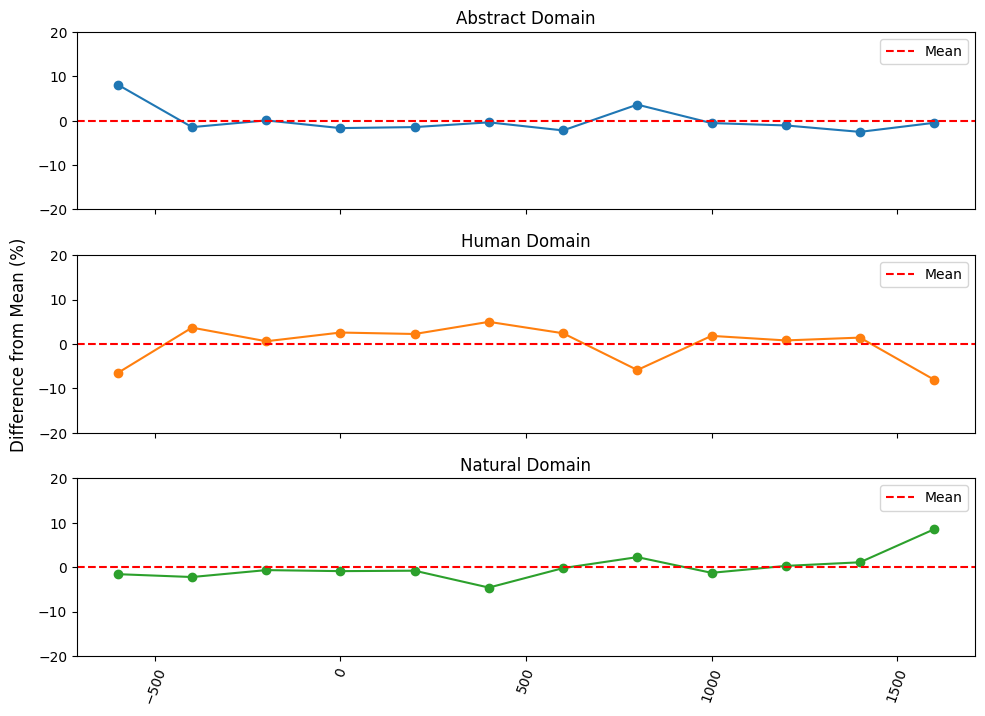

In [17]:
# Calculate the mean percentage for each domain
mean_percentages = df_time.groupby('domain')['percent'].mean()
mean_percentages.reset_index()['percent'].sum()

import matplotlib.pyplot as plt

# Create a new column for the difference from the mean
df_time['difference_from_mean'] = df_time.apply(lambda row: row['percent'] - mean_percentages[row['domain']], axis=1)


# Create a single graph with three subplots stacked on top of each other
fig, axs = plt.subplots(3, 1, figsize=(10, 7), sharex=True)  # Adjust the height (7) as needed

# List of unique domains
domains = df_time['domain'].unique()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Choose nicer colors

random_df = pd.read_csv('domain_variations/random_times.csv', index_col = [0])

for i, domain in enumerate(domains):
    domain_data = df_time[df_time['domain'] == domain]
    axs[i].plot(domain_data['century'], domain_data['difference_from_mean'], marker='o', linestyle='-', color=colors[i])

    # random_data = random_df[random_df['domain'] == domain]
    # axs[i].plot(random_data['century'], random_data['difference_from_mean'], marker='x', linestyle='-', color=colors[i], alpha = 0.5, label = 'Simulated Data')


    axs[i].axhline(y=0, color='r', linestyle='--', label='Mean')
    #axs[i].set_ylabel('Difference from Mean (%)')
    axs[i].set_title(f'{domain}')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    axs[i].legend(loc='upper right')
    
    # Set the y-axis limits to -100 to 100
    axs[i].set_ylim(-20, 20)
    
    axs[i].legend()
    axs[i].grid(False)

# Add a unique ylabel
fig.supylabel('Difference from Mean (%)')

plt.tight_layout()
plt.xticks(rotation=70)
plt.show()

In [16]:
df_stats = df_time[['century', 'domain', 'difference_from_mean']].copy()
domain_variance = df_stats.groupby('domain')['difference_from_mean'].std()
domain_variance

domain
Abstract Domain    2.999578
Human Domain       4.311561
Natural Domain     3.185682
Name: difference_from_mean, dtype: float64

### Qualitative Check for the Low Countries

In [13]:
df_fin_ind = pd.merge(df_individuals_time[['wikidata_id', 'century', 'domain', 'node']], df_individuals[['wikidata_id', 'region_name']])
#df_fin_ind = df_fin_ind[df_fin_ind['region_name']=='Low countries']
df_fin_ind = df_fin_ind.groupby(['region_name', 'century','domain', 'node'])['wikidata_id'].count().reset_index()
df_fin_ind = df_fin_ind[df_fin_ind['domain']=='Natural Domain']
df_fin_ind = df_fin_ind.sort_values('wikidata_id', ascending=False)
df_fin_ind.head(30)

,region_name,century,domain,node,wikidata_id
461,Low countries,1600.0,Natural Domain,geographer,127
321,German world,1600.0,Natural Domain,geographer,99
267,France,1600.0,Natural Domain,geographer,96
265,France,1600.0,Natural Domain,botanist,88
319,German world,1600.0,Natural Domain,botanist,78
427,Italy,1600.0,Natural Domain,botanist,72
173,British Islands,1600.0,Natural Domain,botanist,60
175,British Islands,1600.0,Natural Domain,geographer,54
429,Italy,1600.0,Natural Domain,geographer,49
218,Eastern Europe,1600.0,Natural Domain,geographer,41
